In [1]:
import torch
import string
import time
import math
import random
import unicodedata
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, fc_hidden_dim):
    super().__init__()
    self.hidden_size = hidden_dim
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, fc_hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc_hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input, hidden):
    out, hidden = self.lstm(input.view(1, 1, -1), hidden)
    out = self.fc1(hidden[0])
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out.view(1, -1), hidden

  def init_hidden(self):
    return (torch.zeros(1, 1, self.hidden_size).cuda(), torch.zeros(1, 1, self.hidden_size).cuda())
    #return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

In [ ]:
inputs = []

df = pd.read_csv('address_dataset.csv')
for index, row in df.iterrows():
  inputs.append((row['text'], row['label']))

random.shuffle(inputs)

In [4]:
all_letters = string.ascii_letters + " #.,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, 
# thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

def normalize(line):
    if type(line) != str:
      return " "
    line = line.replace(',', '')
    line = line.lower()
    return line

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    line = normalize(line)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_hidden = 128
n_hidden_2 = 64

lstm = LSTM(n_letters, n_hidden, n_hidden_2)
lstm.to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.0001)

def train(batch):
    optimizer.zero_grad()

    for b in batch:
      text, label = b
      text_tensor = lineToTensor(text)
      label_tensor = torch.tensor([[label]], dtype=torch.float).cuda()
      #label_tensor = torch.tensor([[int(label)]], dtype=torch.float)


      hidden = lstm.init_hidden()
      for i in range(text_tensor.size()[0]):
          output, hidden = lstm(text_tensor[i].cuda(), hidden)
          #output, hidden = lstm(text_tensor[i], hidden)

      loss = loss_fn(output.cuda(), label_tensor)
      #loss = loss_fn(output, label_tensor)

      loss.backward()

    optimizer.step()


    return output, loss.item()

In [6]:
# Keep track of losses for plotting
all_losses = []
batches = 5000

lstm.train()

train_size = int(0.8 * len(inputs))
test_size = len(inputs) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(inputs, [train_size, test_size])

total_loss = 0
train_dataset = list(train_dataset)

for i in range(batches):
    batch = random.sample(train_dataset, 64)
    output, loss = train(batch)
    total_loss += loss

    if i % 250 == 0:
      avg_loss = total_loss / 250 if i != 0 else total_loss
      print("Loss: {}".format(avg_loss))
      all_losses.append(avg_loss)
      total_loss = 0


Loss: 0.634734034538269
Loss: 0.633951114475727
Loss: 0.4137473308686167
Loss: 0.3219783145985566
Loss: 0.33611844858503903
Loss: 0.25798199673666383
Loss: 0.1701115856395918
Loss: 0.1708857908945065
Loss: 0.12814566574889613
Loss: 0.06808449640479375
Loss: 0.10950465523261664
Loss: 0.07445675984325863
Loss: 0.10686058797430632
Loss: 0.06546415514530964
Loss: 0.04076270243567342
Loss: 0.06592814794147762
Loss: 0.04649555617416809
Loss: 0.03842890917741352
Loss: 0.04889007207478244
Loss: 0.03842206243786768


In [7]:
def evaluate(line_tensor):
    hidden = lstm.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

def test(test_inputs):
  correct = 0
  with torch.no_grad():
    for test in test_inputs:

      text, label = test
      output = evaluate(lineToTensor(text).cuda())
      #output = evaluate(lineToTensor(text))

      pred = 1 if output.item() >= 0.5 else 0

      if pred == label:
        correct += 1
  
  print("Accuracy: {}".format(correct / len(test_dataset)))


test(test_dataset)

Accuracy: 0.990468085106383


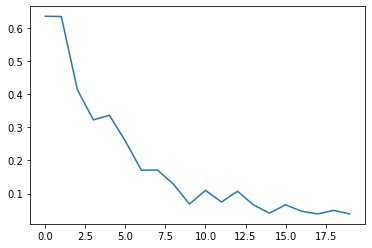

In [8]:
plt.figure()
plt.plot(all_losses)

In [30]:
def predict(input_line):
    print("{}".format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).cuda())
        #output = evaluate(lineToTensor(input_line))
        print(output.item())
        print()

predict('dfasdfa sfdasfds afas')
predict('Hey hey my my rock\'n roll can never die')
predict('1600, Washington DC 20500')
predict('Pennsylvania Avenue, Washington 1600')
predict('1600 Pennsylvania Avenue, Washington DC')
predict('1600 Pennsylvania Avenue, Washington DC 20500')

dfasdfa sfdasfds afas
2.4631994165247306e-05

Hey hey my my rock'n roll can never die
0.0009071114473044872

1600, Washington DC 20500
0.0004033338918816298

Pennsylvania Avenue, Washington 1600
8.703887579031289e-05

1600 Pennsylvania Avenue, Washington DC
0.0008297686581499875

1600 Pennsylvania Avenue, Washington DC 20500
0.9953696131706238



In [18]:
torch.save({
            'batch': 5000,
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'checkpoint.pt')

In [28]:
# checkpoint = torch.load('checkpoint.pt')
# lstm.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# batch = checkpoint['batch']
# loss = checkpoint['loss']